In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline

F:\Users\zzjun\Anaconda3\lib\site-packages\neuro_morpho_toolbox-0.1-py3.7.egg\neuro_morpho_toolbox\
Loading CCF Atlas data...
Loading time: 0.85
Loading CCF brain structure data...
Loading time: 0.02
Loading selected CCF Atlas and Contour data...
Loading time: 5.97


```
import pickle
ns = nmt.neuron_set(r'D:\Handover_Zijun\Janelia_1000_rm')
pickle.dump([ns], open("D:\\Songlin\\Janelia_ns.pickle", "wb"))
```

### read neuron and SUB_list in

In [2]:
import pickle
import pickle


pickle_in = open("D:\\Songlin\\Janelia_ns_flip.pickle","rb")
[ns] = pickle.load(pickle_in)
SUB_list = ns.metadata[ns.metadata.SomaRegion=='SUB'].index.tolist()

In [3]:
selectedNS= ns.metadata[ns.metadata['CellType']== 'SUB']
#selectedNS = selectedNS.append(ns.metadata[ns.metadata['CellType']== 'ProS'])
SUB_list = ns.metadata[ns.metadata.SomaRegion=='SUB'].index.tolist()

### read contour in

In [4]:
import pickle
[interestContour] = pickle.load(open('D:/Songlin/interest_contour.pickle', 'rb'))
[interestArray] = pickle.load(open('D:/Songlin/interest_Arr.pickle', 'rb'))

### Set region names

In [5]:
related_region_name =['CA1','SUB','ProS','MM','AV','ENTm','RE','AM','ENTl','PL','BLA','ILA','COAp','COAa','TR','RSPv','OT','LSc','LSv','LSr','BST']

related_region_id = list(map(nmt.bs.name_to_id, related_region_name))

selected_region_name =  ['CA1','SUB','ProS']
selected_region_id = list(map(nmt.bs.name_to_id, selected_region_name))

### Set region_color_dict
* Consider all the related_region_id 
* Only selected_region_id will be different from others

In [6]:
# Global variables
u_views = ['Coronal', 'Horizontal', 'Sagittal']
#u_color_by = ['SingleCell', 'CellType', 'Subtype', 'Cluster', 'nblast']


view_idx = dict(zip(u_views, [0, 1, 2]))
view_axis = dict(zip(u_views, ["X", "Y", "Z"]))

midline = nmt.annotation.micron_size['z']/2

# Custom settings
# related_region_id includes 19 regions, initialize color to C0
region_color_dict = dict(zip(related_region_id, ["C0" for i in range(len(related_region_id))]))

# Initialize selected regions' color to C1-C7, 7 is len(selected)
for i,cur_region in enumerate(selected_region_id):
    region_color_dict[cur_region] = "C"+str(i+1)

# Set child region to have the same color
for cur_region in related_region_id:
    for cur_child in nmt.bs.get_all_child_id(cur_region):
        region_color_dict[cur_child] = region_color_dict[cur_region]
region_color_dict[0] ='C0'


### fun border_line2 used to plot border colorfully


In [21]:
import colorlover as cl
from neuro_morpho_toolbox.plot import rgb_to_list
def get_single_region_colors(region_list, palette="paired", return_str=False):
    bupu = cl.scales['9']['seq']['BuPu']           
    greens = cl.scales['9']['seq']['Greens']        
    set2 = cl.scales['7']['qual']['Set2']           
    spectral = cl.scales['9']['div']['Spectral']   
    paired = cl.scales['10']['qual']['Paired']     
    mpl_colors = []
    for i in range(9):
        tp = []
        for j in list(mpl.colors.to_rgb("C" + str(i))):
            tp.append(str(int(j * 255)))
        tp = ", ".join(tp)
        tp = "rgb(" + tp + ")"
        mpl_colors.append(tp)
    
    my_palette_dict = {"bupu":bupu,
                   "greens":greens,
                   "set2":set2,
                   "spectral":spectral,
                   "paired":paired,
                   "matplotlib":mpl_colors
                   }    
    margin=0.05
    u_regions = list(set(region_list))
    color_list = cl.to_rgb(cl.interp(my_palette_dict[palette], len(u_regions)))
    if not return_str:
        color_list = [rgb_to_list(i) for i in color_list]
    group_colors = dict(zip(u_regions, color_list))
    return group_colors



ccf_Contour = np.multiply(nmt.ccfArray,nmt.Contour01)
import matplotlib as mpl
def border_line2(view, position, regions=None, s_thick = 1, ax=None, bkground_ON = False):
    bupu = cl.scales['9']['seq']['BuPu']           
    greens = cl.scales['9']['seq']['Greens']        
    set2 = cl.scales['7']['qual']['Set2']           
    spectral = cl.scales['9']['div']['Spectral']   
    paired = cl.scales['10']['qual']['Paired']     
    mpl_colors = []
    for i in range(9):
        tp = []
        for j in list(mpl.colors.to_rgb("C" + str(i))):
            tp.append(str(int(j * 255)))
        tp = ", ".join(tp)
        tp = "rgb(" + tp + ")"
        mpl_colors.append(tp)
    
    my_palette_dict = {"bupu":bupu,
                   "greens":greens,
                   "set2":set2,
                   "spectral":spectral,
                   "paired":paired,
                   "matplotlib":mpl_colors
                   }    
    margin=0.05
    dpi=80
    enlarge=1.5
    alpha=0.5
    ccf_annotation = nmt.annotation
    # Background image
    nda = np.empty([0, 0])
    xspace = 0
    yspace = 0
    if view.lower() == "coronal":
        nda = (np.max(ccf_annotation.array, axis=0) > 0)  # 3D -> 2D projection
        xspace = ccf_annotation.space['z']
        yspace = ccf_annotation.space['y']
    if view.lower() == "horizontal":
        nda = (np.max(ccf_annotation.array, axis=1) > 0)
        xspace = ccf_annotation.space['z']
        yspace = ccf_annotation.space['x']
    if view.lower() == "sagittal":
        nda = (np.max(ccf_annotation.array, axis=2) > 0).transpose()
        xspace = ccf_annotation.space['y']
        yspace = ccf_annotation.space['x']

    xsize = nda.shape[1]
    ysize = nda.shape[0]

    # Figure settings
    if ax is None:
        figsize = (1 + margin) * xsize * enlarge / dpi, (1 + margin) * ysize * enlarge / dpi
        fig = plt.figure(figsize=figsize, dpi=dpi)
        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])

    extent = (0, xsize * xspace, ysize * yspace, 0)
    if bkground_ON:
        ax.imshow(nda, cmap="Greys", alpha=0.1, extent=extent)
    else:
        ax.imshow(nda, cmap="Greys", alpha=0.0, extent=extent)
    if regions != None:
        regionDIC = get_single_region_colors(regions, palette="paired", return_str=False)
        regionDIC = {'MM': [1.0, 0.7137254901960784, 0.7568627450980392], 
                     'AM': [0.8470588235294118, 0.7490196078431373, 0.8470588235294118], 
                     'COAa': [0.5411764705882353, 0.16862745098039217, 0.8862745098039215], 
                     'BLA': [0.9019607843137255, 0.9019607843137255, 0.9803921568627451], 
                     'OT': [0.2549019607843137, 0.4117647058823529, 0.8823529411764706],
                     'LSv': [0.6901960784313725, 0.7686274509803922, 0.8705882352941177], 
                     'LSc': [0.3, 0.0019607843137255, 0.5019607843137255], 
                     'ENTm': [0.11764705882352941, 0.5647058823529412, 1.0], 
                     'BST': [0.0, 0.807843137254902, 0.8196078431372549], 
                     'AV': [0.5294117647058824, 0.807843137254902, 0.9803921568627451], 
                     'RE': [1.0, 0.6470588235294118, 0.0], 'ENTl': [0.9803921568627451, 0.9803921568627451, 0.8235294117647058],
                     'TR': [0.1803921568627451, 0.5450980392156862, 0.3411764705882353], 
                     'SUB': [0.5294117647058824, 0.807843137254902, 0.9215686274509803], 
                     'LSr': [1.0, 0.6274509803921569, 0.47843137254901963], 
                     'CA1': [1.0, 0.8431372549019608, 0.0],#gold color instead of yellow 
                     'PL': [0.6627450980392157, 0.6627450980392157, 0.6627450980392157], 
                     'RSPv': [0.6901960784313725, 0.8784313725490196, 0.9019607843137255], 
                     'COAp': [0.5647058823529412, 0.9333333333333333, 0.5647058823529412], 
                     'ILA': [0.4980392156862745, 1.0, 0.6666666666666666], 'ProS': [0.9411764705882353, 1.0, 1.0]}

        regionDIC.update({"SUB":'red',"ProS":'green'})#,"CA1":'yellow'})
        #print(regionDIC)
        if view.lower() == "coronal":    #x   z,y
            #assert position.all() < nmt.annotation.array.shape[0],"Input position must within the brain region"
            for iter_Region in regions:
                x_range = np.array([])
                y_range = np.array([])
                if type(iter_Region) == str:
                    x_range = np.append(x_range,np.where(ccf_Contour[position,:,:] == nmt.bs.name_to_id(iter_Region))[1])
                    y_range = np.append(y_range,np.where(ccf_Contour[position,:,:] == nmt.bs.name_to_id(iter_Region))[0])
                    ax.scatter(xspace * x_range, yspace* y_range, marker="o", s = s_thick ,c = regionDIC[iter_Region])
        if view.lower() == "horizontal": #y z,x
            #assert position.all() < nmt.annotation.array.shape[1],"Input position must within the brain region"
            for iter_Region in regions:
                x_range = np.array([])
                y_range = np.array([])
                if type(iter_Region) == str:
                    x_range = np.append(x_range,np.where(ccf_Contour[:,position,:] == nmt.bs.name_to_id(iter_Region))[1])
                    y_range = np.append(y_range,np.where(ccf_Contour[:,position,:] == nmt.bs.name_to_id(iter_Region))[0])
                    ax.scatter(xspace * x_range, yspace* y_range, marker="o", s = s_thick ,c = regionDIC[iter_Region])
        if view.lower() == "sagittal":   #z  y,x
            #assert position.all() < nmt.annotation.array.shape[2],"Input position must within the brain region"
            for iter_Region in regions:
                x_range = np.array([])
                y_range = np.array([])
                if type(iter_Region) == str:
                    x_range = np.append(x_range,np.where(ccf_Contour[:,:,position] == nmt.bs.name_to_id(iter_Region))[0])
                    y_range = np.append(y_range,np.where(ccf_Contour[:,:,position] == nmt.bs.name_to_id(iter_Region))[1])
                    ax.scatter(xspace * x_range, yspace* y_range, marker="o", s = s_thick ,c = regionDIC[iter_Region])
    return

### fun plot_swc_mpl used to plot swc segment

In [8]:
def plot_swc_mpl(segment, specific_L,
                 color='rgb(255, 0, 0)', view_by='Horizontal',
                 linewidth=1, alpha=1,
                 ax=None):
    assert view_by in u_views, " ".join((["option 'view_by' should be one of the following: "] + u_views))
    Xe, Ye, Ze, Te = segment
    specific_Dic = { temp_Region[i] : i+1 for i in range(0, len(temp_Region)) }
    #print('The specific axon regions for this neuron is '+str(specific_L))
    if view_by == "Coronal":
        tp = pd.DataFrame({'heng': Ze, 'zong': Ye, 'Te': Te})
    if view_by == "Horizontal":
        tp = pd.DataFrame({'heng': Ze, 'zong': Xe, 'Te': Te})
    if view_by == "Sagittal":
        tp = pd.DataFrame({'heng': Xe, 'zong': Ye, 'Te': Te})

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if color == "classical":
        ax.plot(tp.heng[tp.Te == 2], tp.zong[tp.Te == 2], c='r', linewidth=linewidth, alpha=alpha)
        ax.plot(tp.heng[tp.Te == 3], tp.zong[tp.Te == 3], c='b', linewidth=linewidth, alpha=alpha)
        ax.plot(tp.heng[tp.Te == 4], tp.zong[tp.Te == 4], c='magenta', linewidth=linewidth, alpha=alpha)
    if color.startswith('rgb'):
        ax.plot(tp.heng, tp.zong,
                c=rgb_to_list(color),
                linewidth=linewidth, alpha=alpha)
    if isinstance(color, list):
        ax.plot(tp.heng, tp.zong,
                c=color,
                linewidth=linewidth, alpha=alpha)
    # The following part is customized for this script
    if color == 'region':
        # The 'type' slot is regarded as 'region id'
        u_regions = sorted(list(set(Te)))
        for i,cur_region in enumerate(u_regions):
            if cur_region == 0:
                cur_name = 'Others'
                ax.plot(tp.heng[tp.Te == cur_region], 
                            tp.zong[tp.Te == cur_region], 
                            c=region_color_dict[cur_region], 
                            linewidth=linewidth, alpha=alpha,
                            label= 'Others',
                           )           
            elif nmt.bs.id_to_name(cur_region) in specific_L:
                cur_name = nmt.bs.id_to_name(cur_region)
                ax.plot(tp.heng[tp.Te == cur_region], 
                            tp.zong[tp.Te == cur_region], 
                            c=region_color_dict[cur_region], 
                            linewidth=linewidth, alpha=alpha,
                            label=cur_name + '_'+str(specific_Dic[cur_name]),
                           )                
            else:
                cur_name = nmt.bs.id_to_name(cur_region)#"Others"
#             print(cur_region, region_color_dict[cur_region])
                ax.plot(tp.heng[tp.Te == cur_region], 
                            tp.zong[tp.Te == cur_region], 
                            c=region_color_dict[cur_region], 
                            linewidth=linewidth, alpha=alpha,
                            label=cur_name,
                           )

#     tp = tp[(tp["Te"] == 1)]
#     ax.scatter(tp.heng, tp.zong,
#                c='black',
#                marker="o",
#                s=30)
    ax.legend(loc='upper left')
    return

# def axon_slice(neuron_name, x_position, ax, slice_thickness=250):
#     # 1. Extract branches in cortex
#     neuron = nmt.neuron(swc_path+neuron_name+'.swc')
#     df = neuron.swc.copy()
#     tp = cortex_region_array[
#         np.array(df.x/25, dtype=int).reshape(-1,),
#         np.array(df.y/25, dtype=int).reshape(-1,),
#         np.array(df.z/25, dtype=int).reshape(-1,),
#     ]
#     df['type'] = tp

#     # Horizontal
#     segment = nmt.swc_to_edges(df, keep_invalid=True)
#     plot_swc_mpl(segment, color='region', view_by='Horizontal', ax=ax[0])
#     show_background('Horizontal', int(4000/25), ax=ax[0])

#     df_list = (df[((df.x<(x_position[0]+slice_thickness)) & (df.x>(x_position[0]-slice_thickness)))], 
#                df[((df.x<(x_position[1]+slice_thickness)) & (df.x>(x_position[1]-slice_thickness)))])
#     ax[0].hlines(x_position, 0, nmt.annotation.micron_size['z'], linestyles='dashed', colors='k')

#     # 3. Add border lines
#     for i in range(2):
#         segment = nmt.swc_to_edges(df_list[i], keep_invalid=True)
#         plot_swc_mpl(segment, color='region', view_by='Coronal', ax=ax[i+1])
#         border_line('Coronal', int(x_position[i]/25), 
#                     regions=[1], 
#                     ax=ax[i+1])
#         ax[i+1].set_xlim(0, 6000)
#         ax[i+1].set_ylim(0, 6000)
#         ax[i+1].invert_yaxis()
    
#     return

# fig, ax = plt.subplots(1,3, figsize=(24,8))
# axon_slice('17302_00076', x_position=(7750, 8500), ax=ax, slice_thickness=slice_thickness) #######


In [36]:
import time

from neuro_morpho_toolbox.plot import swc_to_edges
def cell_in_map2(neurons_dict, cell_list, metadata, ccf_annotation,
                view="Horizontal",linewidth = 2000,
                margin=0.05, dpi=80, enlarge=1.5, alpha=0.5, ax=None,
                color="classical", flip_soma=True):
    assert view in u_views, " ".join((["option 'view_by' should be one of the following: "] + u_views))

    # Background image
    nda = np.empty([0, 0])
    xspace = 0
    yspace = 0
    if view.lower() == "coronal":
        nda = (np.max(ccf_annotation.array, axis=0) > 0)  # 3D -> 2D projection
        xspace = ccf_annotation.space['z']
        yspace = ccf_annotation.space['y']
    if view.lower() == "horizontal":
        nda = (np.max(ccf_annotation.array, axis=1) > 0)
        xspace = ccf_annotation.space['z']
        yspace = ccf_annotation.space['x']
    if view.lower() == "sagittal":
        nda = (np.max(ccf_annotation.array, axis=2) > 0).transpose()
        xspace = ccf_annotation.space['y']
        yspace = ccf_annotation.space['x']

    xsize = nda.shape[1]
    ysize = nda.shape[0]

    # Figure settings
    if ax is None:
        figsize = (1 + margin) * xsize * enlarge / dpi, (1 + margin) * ysize * enlarge / dpi
        fig = plt.figure(figsize=figsize, dpi=dpi)
        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])

    extent = (0, xsize * xspace, ysize * yspace, 0)
    ax.imshow(nda, cmap="Greys", alpha=0.2, extent=extent)

    # Plot cells
    
    alpha = 0.7
    
    # Option 2: swc mode
    start_sum = time.time()
    i_p = 0
    for cellname in cell_list:
        # TBI: replace by plot_swc_mpl
        start_sub = time.time()
        i_p = i_p + 1
        # print("Processing progress: %.2f" % (i_p / len(cell_list)))
        Xe, Ye, Ze, Te = swc_to_edges(neurons_dict[cellname].swc)
        tp = pd.DataFrame(columns=['heng', 'zong', 'Te'])
        if view.lower() == "coronal":
            tp = pd.DataFrame({'heng': Ze, 'zong': Ye, 'Te': Te})
        if view.lower() == "horizontal":
            tp = pd.DataFrame({'heng': Ze, 'zong': Xe, 'Te': Te})
        if view.lower() == "sagittal":
            tp = pd.DataFrame({'heng': Xe, 'zong': Ye, 'Te': Te})
            flip_soma = False

        ax.plot(tp.heng, tp.zong,
                    c= color,
                    linewidth=linewidth, alpha=alpha)

        tp = tp[(tp["Te"] == 1)]


        end_sub = time.time()
        # print("Single cell's loading time: %.2f" % (end_sub - start_sub))
    end_sum = time.time()
    print("Total loading time: %.2f" % (end_sum - start_sum))
    return


# Plot single neuron image, slice based on soma location

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Total loading time: 0.08


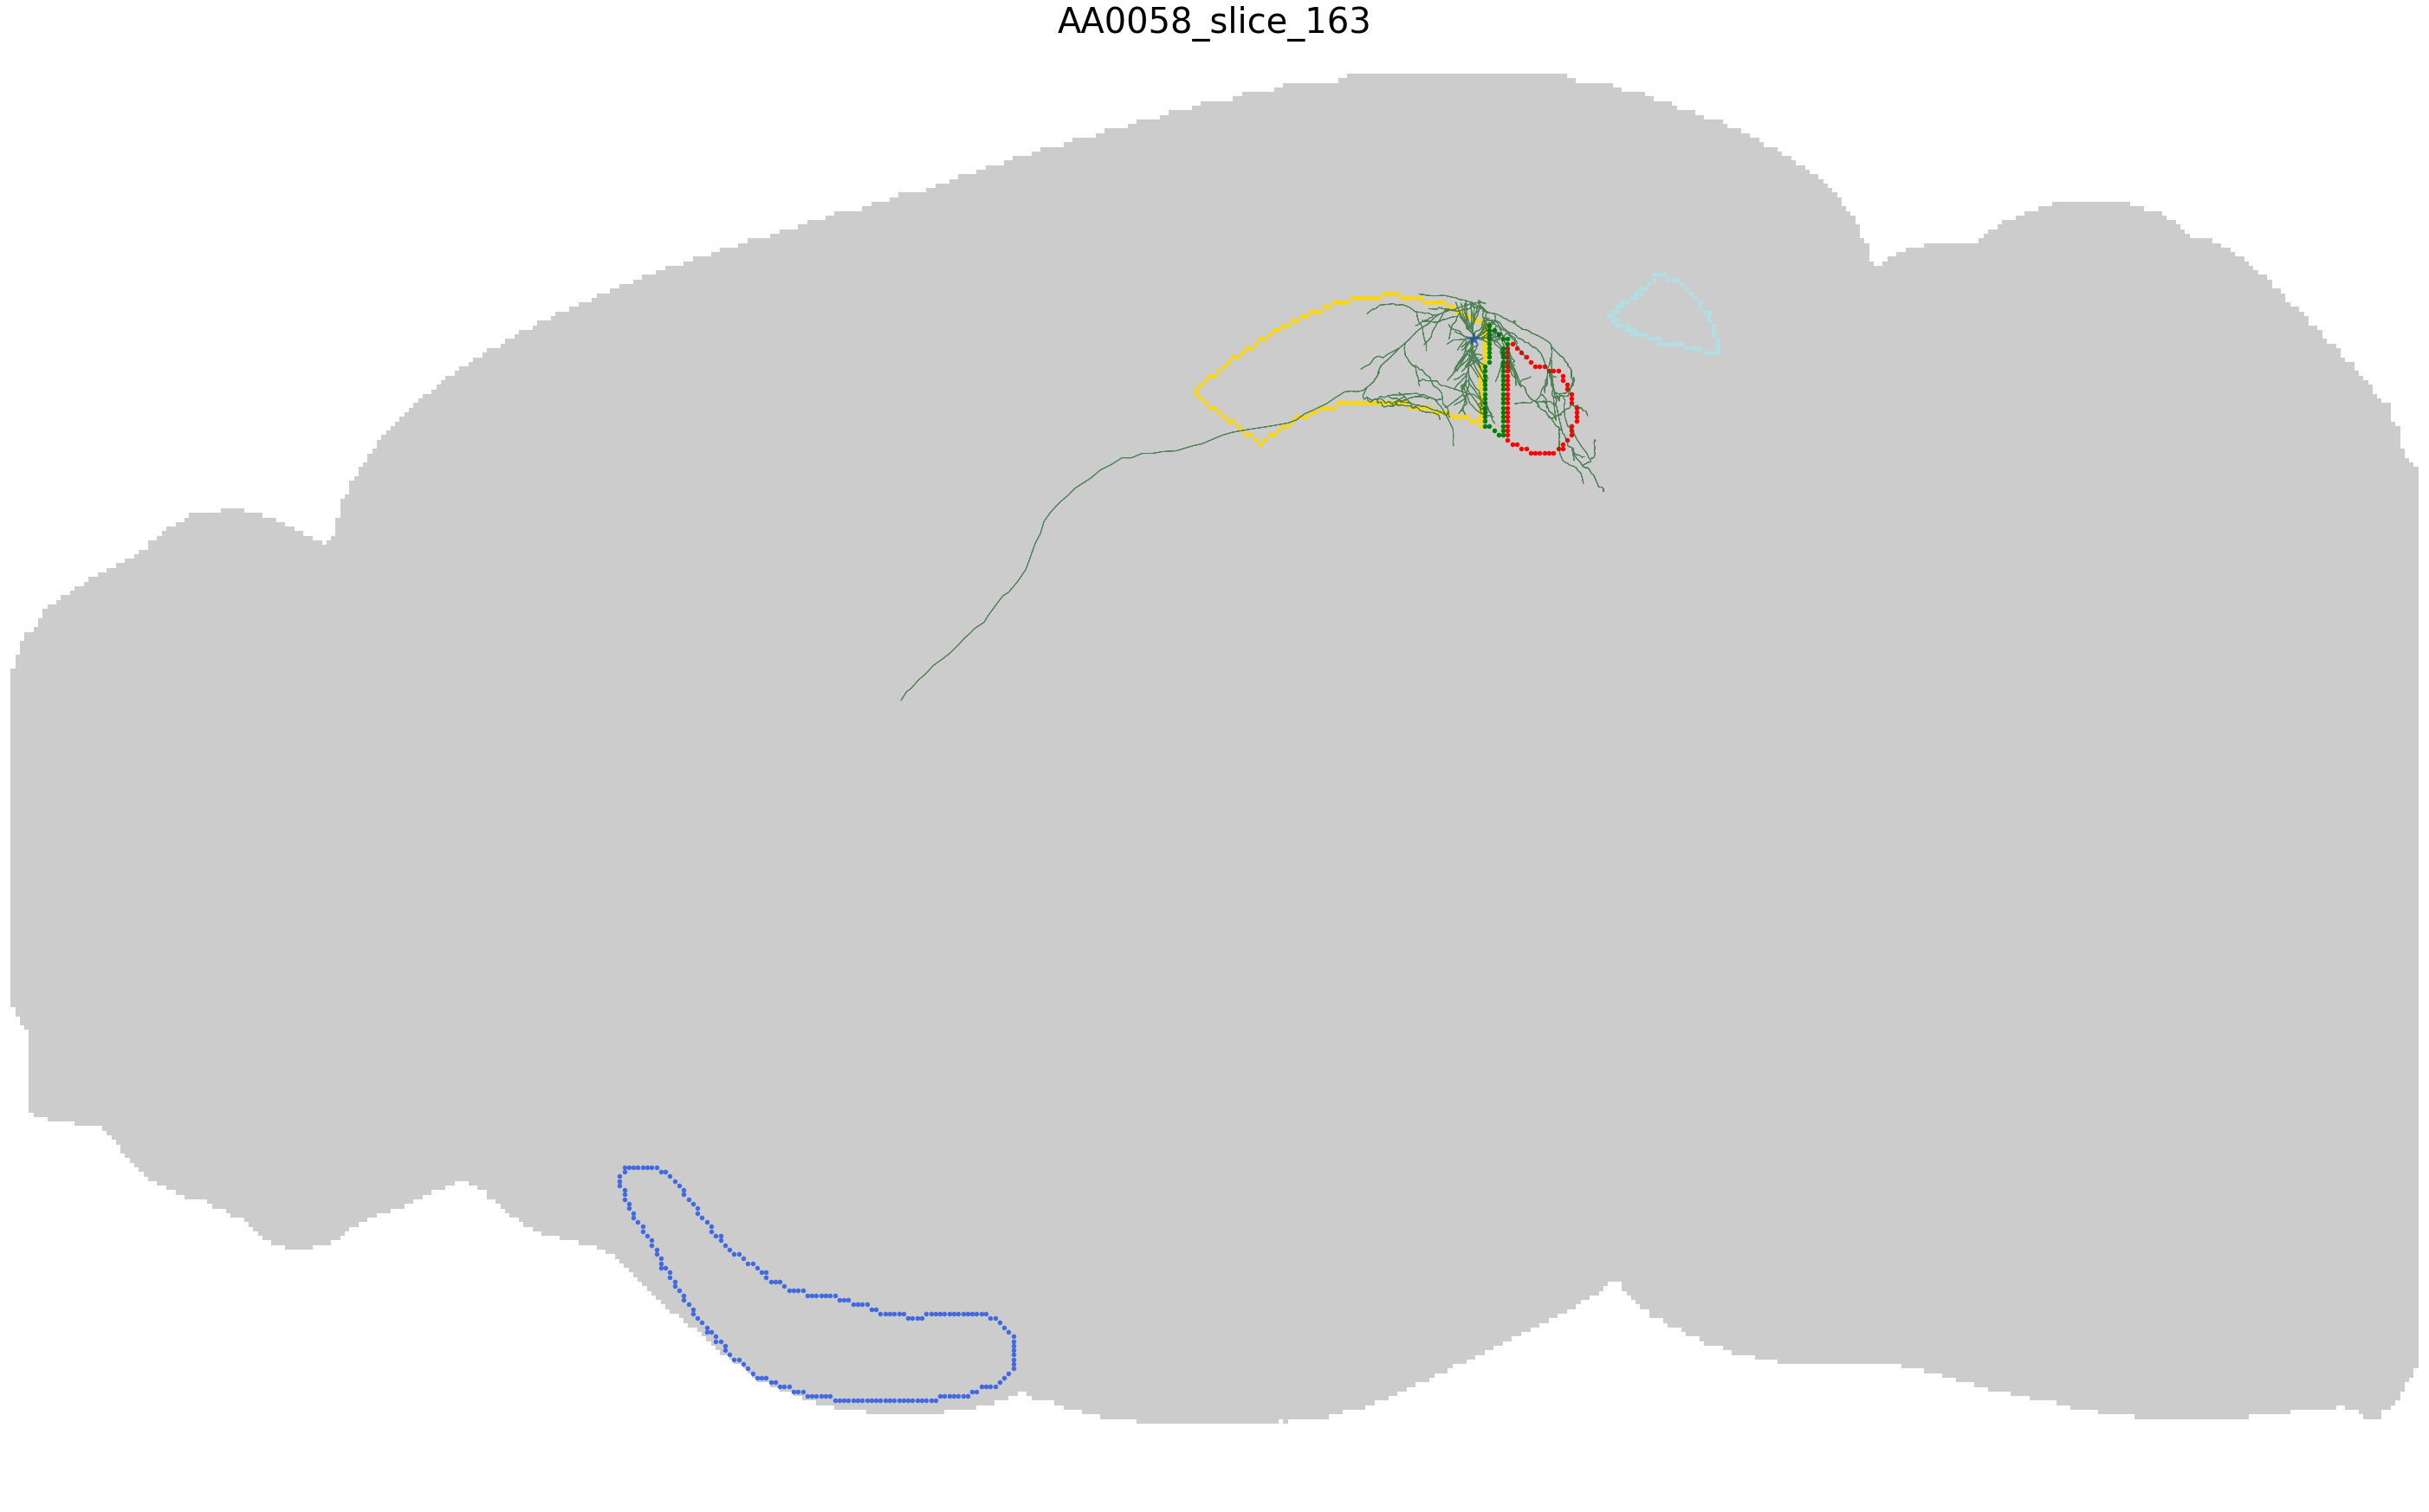

In [54]:
# For CA1 list
import matplotlib.cm as cm
savepath = 'D:\\Songlin\\26Feb'
from neuro_morpho_toolbox.plot import cell_in_map
savepath = os.path.join(savepath, 'CA1')
folder = os.path.exists(savepath)
if not folder:         
    os.makedirs(savepath)  
CA1_list = ns.metadata[ns.metadata.SomaRegion=='CA1'].index.tolist()
NeuronAll = CA1_list
regionList = related_region_name
viewINPUT='Sagittal'
for iterL in NeuronAll:
    [soma_x] = ns.neurons[iterL].soma['x'].values
    [soma_y] = ns.neurons[iterL].soma['y'].values
    [soma_z] = ns.neurons[iterL].soma['z'].values
    fig, ax = plt.subplots(1,1,figsize=(50,100))
    positionINPUT = int(soma_z/25)
    border_line2(viewINPUT, positionINPUT, regions=regionList, s_thick = 20, ax=ax, bkground_ON = False)
    cell_in_map2(ns.neurons,[iterL], ns.metadata, ccf_annotation=nmt.annotation, 
                view=viewINPUT,linewidth = 1, color='#1b6427',alpha=1, ax=ax)
    
    ax.scatter(soma_x, soma_y, c=cm.rainbow(np.linspace(0, 1, 10))[1],marker="*", s = 200  , zorder=1)
    #fig.suptitle(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontsize=20)
    #ax.title.set_text(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontsize=100)#+str(iterc))
    ax.set_title(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontdict={'fontsize': 40, 'fontweight': 'medium'})
    ax.axis('off')
    fig.savefig(os.path.join(savepath,str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT)+'.png'), bbox_inches='tight')
    plt.show()
    break
   

In [ ]:
# For ProS list
import matplotlib.cm as cm
savepath = 'D:\\Songlin\\26Feb'
from neuro_morpho_toolbox.plot import cell_in_map
savepath = os.path.join(savepath, 'ProS')
folder = os.path.exists(savepath)
if not folder:         
    os.makedirs(savepath)  
ProS_list = ns.metadata[ns.metadata.SomaRegion=='ProS'].index.tolist()
NeuronAll = ProS_list
regionList = related_region_name
viewINPUT='Sagittal'
for iterL in NeuronAll:
    [soma_x] = ns.neurons[iterL].soma['x'].values
    [soma_y] = ns.neurons[iterL].soma['y'].values
    [soma_z] = ns.neurons[iterL].soma['z'].values
    fig, ax = plt.subplots(1,1,figsize=(50,100))
    positionINPUT = int(soma_z/25)
    border_line2(viewINPUT, positionINPUT, regions=regionList, s_thick = 20, ax=ax, bkground_ON = False)
    cell_in_map2(ns.neurons,[iterL], ns.metadata, ccf_annotation=nmt.annotation, 
                view=viewINPUT,linewidth = 1, color='#1b6427',alpha=1, ax=ax)
    
    ax.scatter(soma_x, soma_y, c=cm.rainbow(np.linspace(0, 1, 10))[1],marker="*", s = 200  , zorder=1)
    #fig.suptitle(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontsize=20)
    #ax.title.set_text(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontsize=100)#+str(iterc))
    ax.set_title(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontdict={'fontsize': 40, 'fontweight': 'medium'})
    ax.axis('off')
    fig.savefig(os.path.join(savepath,str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT)+'.png'), bbox_inches='tight')
    plt.show()
    break
   

In [ ]:
# For SUB list
import matplotlib.cm as cm
savepath = 'D:\\Songlin\\26Feb'
from neuro_morpho_toolbox.plot import cell_in_map
savepath = os.path.join(savepath, 'SUB')
folder = os.path.exists(savepath)
if not folder:         
    os.makedirs(savepath)  
SUB_list = ns.metadata[ns.metadata.SomaRegion=='SUB'].index.tolist()
NeuronAll = SUB_list
regionList = related_region_name
viewINPUT='Sagittal'
for iterL in NeuronAll:
    [soma_x] = ns.neurons[iterL].soma['x'].values
    [soma_y] = ns.neurons[iterL].soma['y'].values
    [soma_z] = ns.neurons[iterL].soma['z'].values
    fig, ax = plt.subplots(1,1,figsize=(50,100))
    positionINPUT = int(soma_z/25)
    border_line2(viewINPUT, positionINPUT, regions=regionList, s_thick = 20, ax=ax, bkground_ON = False)
    cell_in_map2(ns.neurons,[iterL], ns.metadata, ccf_annotation=nmt.annotation, 
                view=viewINPUT,linewidth = 1, color='#1b6427',alpha=1, ax=ax)
    
    ax.scatter(soma_x, soma_y, c=cm.rainbow(np.linspace(0, 1, 10))[1],marker="*", s = 200  , zorder=1)
    #fig.suptitle(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontsize=20)
    #ax.title.set_text(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontsize=100)#+str(iterc))
    ax.set_title(str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT), fontdict={'fontsize': 40, 'fontweight': 'medium'})
    ax.axis('off')
    fig.savefig(os.path.join(savepath,str(iterL.split('\\')[-1])+"_slice_"+str(positionINPUT)+'.png'), bbox_inches='tight')
    plt.show()
    break
   